In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

In [1]:
from pathlib import Path

from forecasting_models.univariate_models.lstm.model import LSTMForecastModel
import numpy as np
from data_utils.csv_utils import read_timeseries_csv


lstm_model = LSTMForecastModel(Path("__file__").parent / Path("examples/configs/lstm/lstm_example_6_step.yaml"))

2024-05-02 16:54:06.043989: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 16:54:06.045063: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 16:54:06.052859: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 16:54:06.146628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 16:54:08.708302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

<Axes: xlabel='timestamp'>

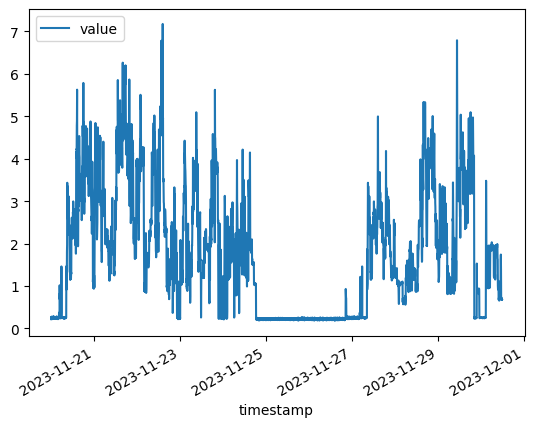

In [2]:
train_df = read_timeseries_csv(lstm_model.config.data_path)
train_df.plot()

In [3]:
import tensorflow as tf

tf.random.set_seed(50)
np.random.seed(50)


In [ ]:
from tensorflow.keras.layers import LSTM

history = lstm_model.train(
    custom_inner_layers=[
        LSTM(64),
    ]
)

<Axes: xlabel='timestamp'>

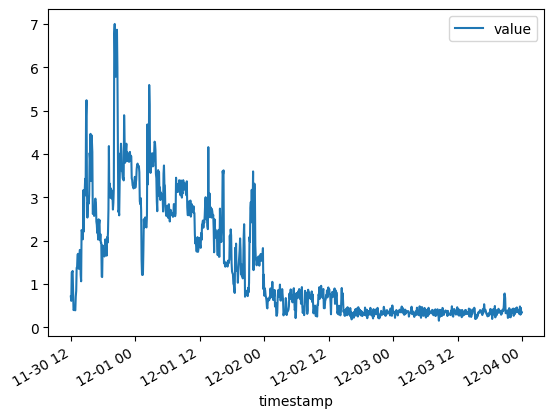

In [5]:
test_df = read_timeseries_csv(Path("./examples/sample_data/univar_data/cpu_example_5min_TEST.csv"))
test_df.plot()

In [6]:
init_inputs = train_df[-lstm_model.config.forecasting_parameters.input_width:]
print(init_inputs)

actuals, preds = lstm_model.test(
    test_df,
    init_inputs=init_inputs,
)

                        value
timestamp                    
2023-11-30 11:30:22  0.689084
2023-11-30 11:35:22  0.715023
2023-11-30 11:40:22  0.724526
2023-11-30 11:45:22  0.674317
2023-11-30 11:50:22  0.685506
2023-11-30 11:55:22  0.682820


In [7]:
test_eval_val, test_eval_df = lstm_model.evaluate_test(actuals, preds, method="mape")

In [8]:
print(test_eval_df)

                       actual  predicted      diff
2023-11-30 12:00:22  0.710193   0.826946 -0.116753
2023-11-30 12:05:22  0.610811   0.886676 -0.275865
2023-11-30 12:10:22  1.269129   0.912954  0.356176
2023-11-30 12:15:22  1.274023   0.913584  0.360439
2023-11-30 12:20:22  1.301465   0.975677  0.325788
...                       ...        ...       ...
2023-12-03 23:35:22  0.481985   0.470403  0.011582
2023-12-03 23:40:22  0.292546   0.485611 -0.193065
2023-12-03 23:45:22  0.450036   0.491979 -0.041944
2023-12-03 23:50:22  0.322604   0.526843 -0.204239
2023-12-03 23:55:22  0.345922   0.546774 -0.200852

[1008 rows x 3 columns]


In [9]:
print(test_eval_val)

38.10607519017425


<Axes: >

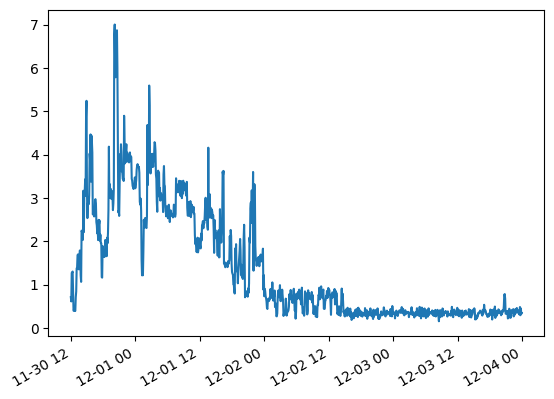

In [10]:
actuals.plot()

<Axes: >

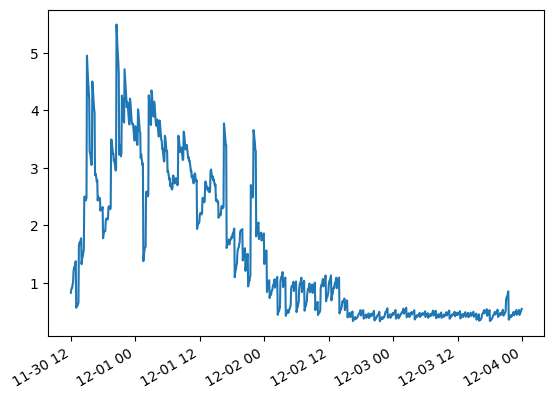

In [11]:
preds.plot()

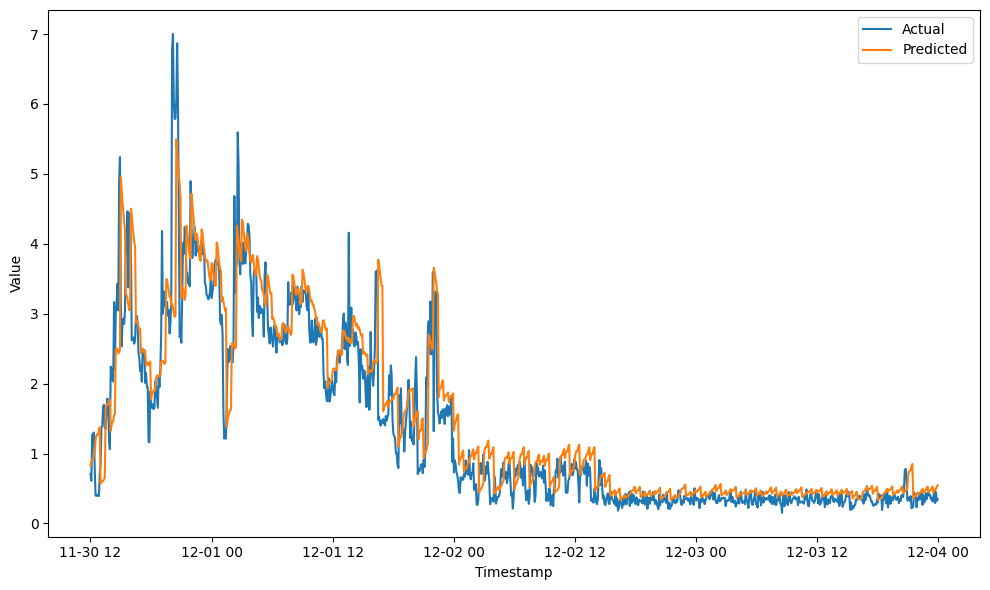

In [12]:
from forecasting_models.general_plotter import GeneralPlotter

GeneralPlotter.plot_two_series(actuals, preds, plot_labels=("Actual", "Predicted"))

In [13]:
anomaly_df = lstm_model.flag_anomalies(actuals, preds, 5)

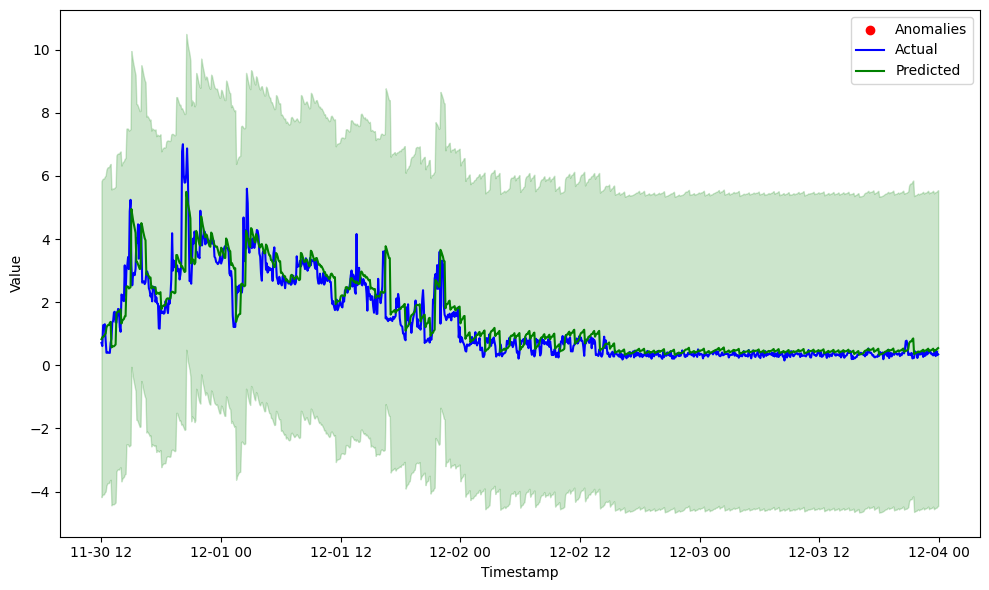

In [14]:
GeneralPlotter.plot_anomalies(anomaly_df, 5)

In [15]:
single_shot_prediction_inputs = train_df[:lstm_model.config.forecasting_parameters.input_width][lstm_model.config.target_variable]
print(single_shot_prediction_inputs)

timestamp
2023-11-20 00:00:22    0.219111
2023-11-20 00:05:22    0.270201
2023-11-20 00:10:22    0.236511
2023-11-20 00:15:22    0.274957
2023-11-20 00:20:22    0.221884
2023-11-20 00:25:22    0.277397
Name: value, dtype: float64


In [16]:
single_shot_predictions = lstm_model.predict(single_shot_prediction_inputs)
print(single_shot_predictions)

2023-11-20 00:30:22    0.295302
2023-11-20 00:35:22    0.302355
2023-11-20 00:40:22    0.307103
2023-11-20 00:45:22    0.315751
2023-11-20 00:50:22    0.327577
2023-11-20 00:55:22    0.338259
Freq: 5min, dtype: float64


In [17]:
single_shot_prediction_actuals = train_df[
    lstm_model.config.forecasting_parameters.input_width:(
            lstm_model.config.forecasting_parameters.input_width + lstm_model.config.forecasting_parameters.output_width
        )][lstm_model.config.target_variable]

single_shot_eval_val, single_shot_eval_df = lstm_model.evaluate_prediction(single_shot_prediction_actuals, method="mse")

In [18]:
print(single_shot_eval_df)

                       actual  predicted      diff
2023-11-20 00:30:22  0.244030   0.295302 -0.051272
2023-11-20 00:35:22  0.252181   0.302355 -0.050175
2023-11-20 00:40:22  0.235366   0.307103 -0.071737
2023-11-20 00:45:22  0.272162   0.315751 -0.043589
2023-11-20 00:50:22  0.221480   0.327577 -0.106097
2023-11-20 00:55:22  0.262705   0.338259 -0.075554


In [19]:
print(single_shot_eval_val)

0.004859576062578053
